# Coding Assignment 2

Author: Ryan Fogle (rsfogle2@illinois.edu)

UIN: 652628818

## Part 1: Implement Lasso

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Load Data

In [2]:
myData = pd.read_csv("Coding2_Data.csv")
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

In [3]:
X.shape, len(y)

((506, 13), 506)

### CD for Lasso

In [4]:
import numpy.typing as npt

def one_var_lasso(r: npt.NDArray, x: npt.NDArray, lam):
    
    #################
    # Your CODE
    #################
    
    # x == z
    # v == r

    z2 = (x.T @ x).sum()
    a = r.T @ x / z2
    n = 2 * x.shape[0] * lam / z2

    if a > n/2:
        return a - n/2
    elif np.abs(a) <= n/2:
        return 0
    elif a < -n/2:
        return a + n/2

In [5]:
from sklearn.preprocessing import StandardScaler

def MyLasso(X, y, lam_seq, maxit = 100):
    
    # Input
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda 
    
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix 
    #    with the first row being the intercept sequence 

  
    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
    
    ##############################
    # YOUR CODE: 
    # (1) newX = Standardizad X; 
    # (2) Record the centers and scales used in (1) 
    ##############################
    scaler = StandardScaler()

    newX = scaler.fit_transform(X)
    # print(scaler.mean_)
    # print(X.shape)

    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y

    
    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b 
    
    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[, 1]
    ##############################

    # scale back
    B[1:, :] = B[1:, :] / scaler.scale_.reshape(-1,1)
    
    # Add in new intercepts
    B[0, :] = (- B[1:, :] * scaler.mean_.reshape(-1, 1) / scaler.scale_.reshape(-1, 1)).sum(axis=0)
    
    return(B)

In [6]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

(-8.35, -0.6499999999999999, -0.30999458351285203, 0.49974219884805027)

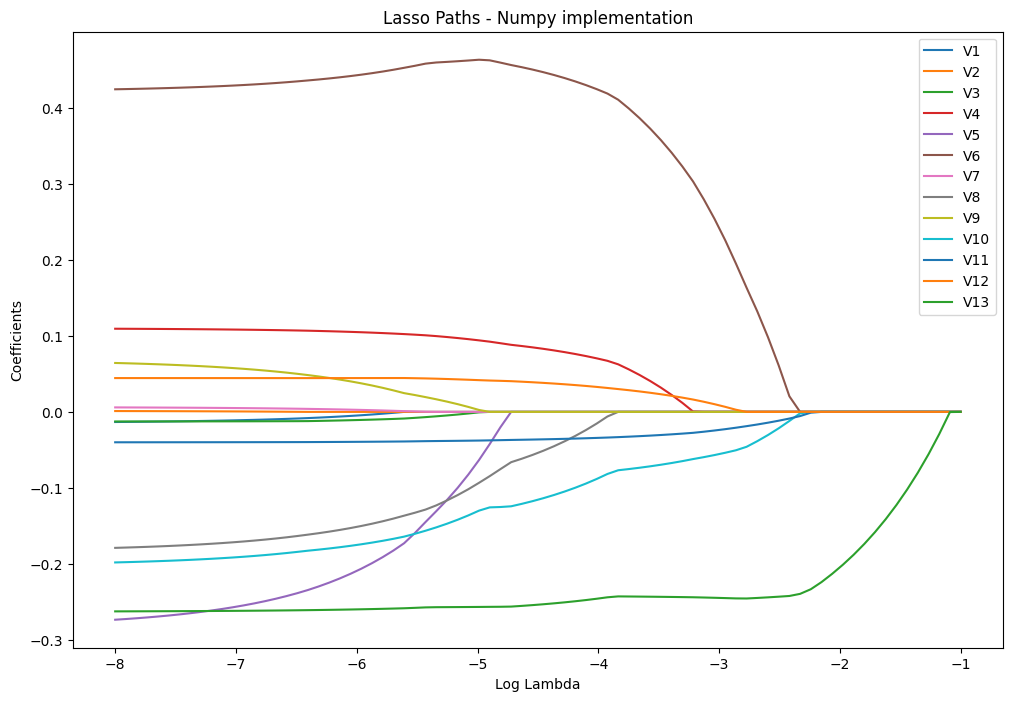

In [7]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

## Part II: Simulation Study

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [9]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_Data2.csv"
myData = pd.read_csv(url)
# myData.head()
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)

In [10]:
X.shape, len(Y)

((506, 91), 506)

Generate test-train split

In [32]:
# from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = LinearRegression().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

def simulate(X, Y):

    # splitting needs to be done this way, or the PCA class breaks :(
    n = len(Y)
    indices = np.arange(0, n)
    np.random.shuffle(indices)
    test_ind = indices[:int(np.floor(0.25*n))]
    train_ind = indices[len(test_ind):]

    # Splitting the data into training and testing sets
    X_train = X.iloc[train_ind]
    y_train = Y[train_ind]
    X_test = X.iloc[test_ind]
    y_test = Y[test_ind]

    # We need to scale data for Ridge and Lasso because they cannot normalize like R. 
    # Scaler
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_test_scale = scaler.transform(X_test)

    # full linear model
    full = LinearRegression()
    full.fit(X_train, y_train)

    # Ridge regression
    ridge_alphas = np.logspace(-10, 1, 100)
    ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10, scoring = 'neg_mean_squared_error')
    ridgecv.fit(X_train_scale, y_train)
    
    ridge_model = Ridge(alpha = ridgecv.alpha_)
    ridge_model.fit(X_train_scale, y_train)

    # Lasso
    lasso_alphas = np.logspace(-10, 1, 100)
    lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
    lassocv.fit(X_train_scale, y_train)

    mean_mse = np.mean(lassocv.mse_path_, axis=1)
    std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10) 

    cv_alphas = lassocv.alphas_
    min_idx = np.argmin(mean_mse)

    alpha_min = cv_alphas[min_idx]

    threshold = mean_mse[min_idx] + std_mse[min_idx]
    alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

    # Lasso with alpha_min
    lasso_model_min = Lasso(alpha = alpha_min, max_iter=10000)
    lasso_model_min.fit(X_train_scale, y_train)

    # Lasso with alpha_1se
    lasso_model_1se = Lasso(alpha = alpha_1se, max_iter=10000)
    lasso_model_1se.fit(X_train_scale, y_train)

    # Refit with alpha_1se
    nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
    lm_refit = LinearRegression()
    lm_refit.fit(X_train.iloc[:, nonzero_indices], y_train)

    # perform PCR and train linear model.
    pcr = PCR()
    pcr.fit(X_train.to_numpy(), y_train.to_numpy())
    
    # print(X_test.columns)
    return (mean_squared_error(y_test, full.predict(X_test)), # full
            mean_squared_error(y_test, ridge_model.predict(X_test_scale)), # ridge
            mean_squared_error(y_test, lasso_model_min.predict(X_test_scale)), # lasso min
            mean_squared_error(y_test, lasso_model_1se.predict(X_test_scale)), # lasso 1se
            mean_squared_error(y_test, lm_refit.predict(X_test.iloc[:, nonzero_indices])), # lasso 1se refit
            mean_squared_error(y_test, pcr.predict(X_test.to_numpy()))
            )



In [33]:
from tqdm import tqdm
import warnings

# I was getting a bunch of convergence errors earlier, this helped suppress them. 
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
data = []
n_sims = 50

for i in tqdm(range(n_sims), total=n_sims):
    data.append(simulate(X,Y))

df = pd.DataFrame(data, columns=['Full', 'Ridge.min', 'Lasso.min', 'Lasso.1se', 'L.Refit', 'PCR'])
df.head()

100%|██████████| 50/50 [05:33<00:00,  6.68s/it]


,Full,Ridge.min,Lasso.min,Lasso.1se,L.Refit,PCR
0,0.031189,0.032180,0.033334,0.032146,0.033867,0.033583
1,0.028011,0.025101,0.026167,0.026257,0.027726,0.029169
2,0.026714,0.026957,0.027747,0.027984,0.025755,0.031293
3,0.030042,0.030036,0.031338,0.029267,0.033270,0.033872
4,0.028285,0.024044,0.025102,0.030709,0.029341,0.024747


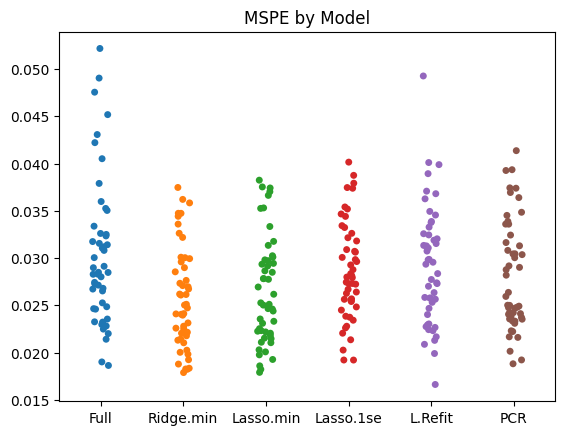

In [36]:
import seaborn as sns

plt.title('MSPE by Model')
sns.stripplot(df)
plt.show()

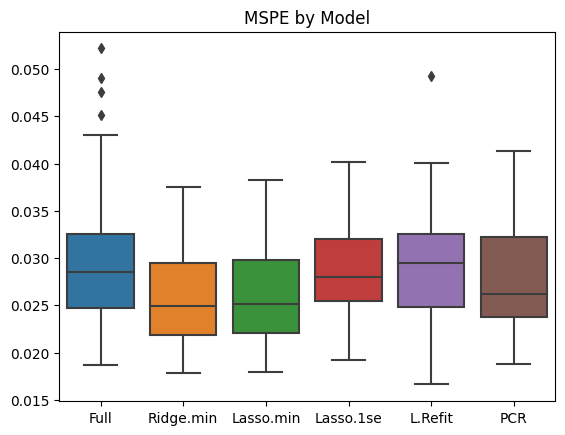

In [37]:
plt.title('MSPE by Model')
sns.boxplot(df)
plt.show()